In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import PIL
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D,Conv2DTranspose,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

from importlib import reload 
from monk import Dataset
   
from PIL import Image 
import PIL 
  


In [3]:
import ncut_loss
import build_Unet
import build_Wnet
import getData

In [4]:
from datasets import get_damaged_generator
from datasets import get_non_damaged_generator
from datasets import get_mixed_generator
import seaborn as sns
import pandas as pd

In [5]:
from getData import get_generator

# DATASETS

In [6]:
TRAIN_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_0.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_1.json"]
TEST_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_3.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_4.json"]


In [82]:
damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True)
non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False)

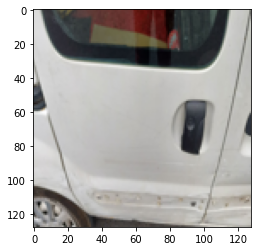

In [86]:
damaged_samples = damaged_generator.__getitem__(5)
plt.imshow((damaged_samples[0]+1)/2)


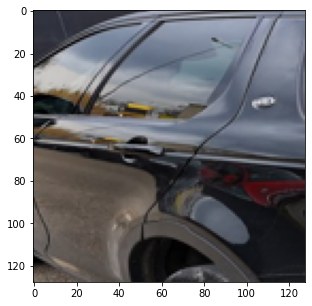

In [85]:
no_damaged_samples = non_damaged_generator.__getitem__(np.random.randint(1,1000))
plt.figure(figsize=(5,5))
plt.imshow((no_damaged_samples[0]+1)/2)

In [10]:
print(len(damaged_generator))
print(len(non_damaged_generator))

4491
5371


# MODEL

In [11]:
neighbor_filter=ncut_loss.neighbor_filter((128,128))

In [138]:
#encoder = build_Unet.build_Unet(K=4,stages = [1,2,3,4],filters = 64,type='encoder',input_size=128,use_dropout=False)
#decoder = build_Unet.build_Unet(K=4,stages = [1,2,3,4],filters = 64,type='decoder',input_size=128,use_dropout=False)
#wn = build_Wnet.Wnet(encoder,decoder,(128,128))

K=10
INPUT_DIM=128
USE_DROPOUT=False

encoder = build_Unet.Unet(K=K,type='encoder',input_size=INPUT_DIM,do_dropout=USE_DROPOUT)
decoder = build_Unet.Unet(K=K,type='decoder',input_size=INPUT_DIM,do_dropout=USE_DROPOUT)
wn = build_Wnet.Wnet(encoder,decoder,(INPUT_DIM,INPUT_DIM))


def custom_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)**2

# Compile the model
wn.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.003),
    loss_fn_segmentation = ncut_loss.compute_soft_ncuts,
    loss_fn_reconstruction = tf.keras.losses.MeanSquaredError()
)


In [161]:
wn.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/WnetDenoiser/ckpt900")

ValueError: Shapes (1, 1, 64, 10) and (1, 1, 64, 18) are incompatible

In [ ]:
def rescale(image):
    return( (((image+1)/2)*255 ).astype("uint8") )

In [ ]:
import tensorflow_addons as tfa
def visualise_seg(image,encoder):
    
    #input_noisy = tfa.image.gaussian_filter2d(image,(10,10),5) + np.random.normal(0, 0.1, image.shape)
    
    sigma=3
    blur_kernel=5
    noise_amp=0.1
    
    image_blurred = tfa.image.gaussian_filter2d( image,(blur_kernel,blur_kernel),sigma)
    noise = np.random.normal(0, noise_amp, image.shape)
    image_blurred = image_blurred + noise
    input_noisy = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)
    
    
    input_noisy = tf.expand_dims(input_noisy, 0)
    print(image.shape)
    
    seg = encoder(input_noisy)
    ag = tf.math.argmax(seg, axis=-1, output_type=tf.dtypes.int64)
        
    
    
    
    res_blur = wn(input_noisy).numpy()[0]
    res_blur = rescale(res_blur)

    plt.figure(figsize=(15,15))

    plt.subplot(1,4,1)
    plt.imshow(rescale(np.array(input_noisy)[0]))
    plt.subplot(1,4,2)
    plt.imshow(ag[0])
    plt.subplot(1,4,3)
    plt.imshow((res_blur))
    plt.subplot(1,4,4)
    plt.imshow(rescale(np.array(image)))
   

    
    return(ag)

(128, 128, 3)


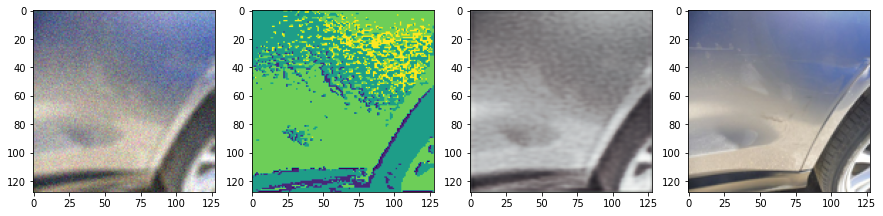

In [162]:
ag = visualise_seg(damaged_samples[6],wn.encoder)


(128, 128, 3)


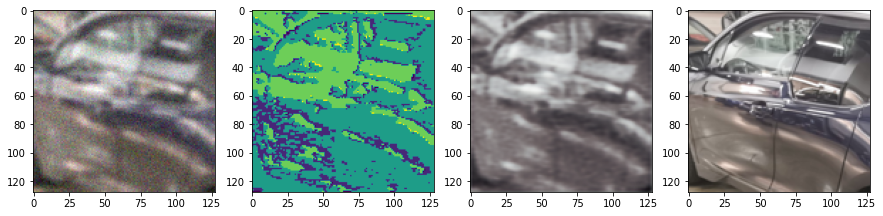

In [152]:
ag = visualise_seg(no_damaged_samples[6],wn.encoder)


(128, 128, 3)


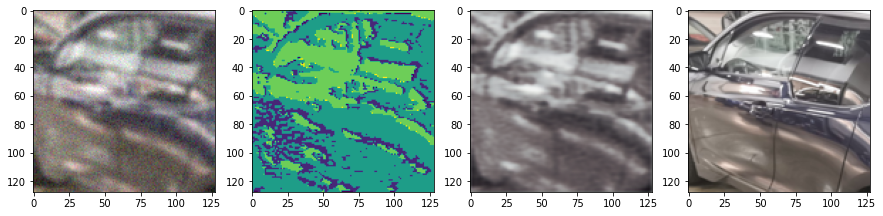

In [163]:
ag = visualise_seg(no_damaged_samples[6],wn.encoder)


In [159]:
dams_reconstruction = []
no_dams_reconstruction = []

dams_seg = []
no_dams_seg = []

#damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True)
#non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False)




sigma=5
blur_kernel=10
noise_amp=0.1

for i in range(0,3):
    print(i)
    no_dams = tf.convert_to_tensor(non_damaged_generator.__getitem__(i))   
    dams = tf.convert_to_tensor(damaged_generator.__getitem__(i))
    for no_dam in no_dams:
      
        input_ = no_dam

        image_blurred = tfa.image.gaussian_filter2d( no_dam,(blur_kernel,blur_kernel),sigma)
        noise = np.random.normal(0, noise_amp, no_dam.shape)
        image_blurred = image_blurred + noise
        input_noisy = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)

        input_noisy=tf.expand_dims(input_noisy,0)
        print(input_noisy.shape)
        #plt.imshow(rescale(np.array(input_noisy))[0])

        seg = wn.encoder(input_noisy)
        seg_loss = ncut_loss.compute_soft_ncuts(tf.expand_dims(input_,0),seg,neighbor_filter).numpy()

        reconstruction = wn(input_noisy)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(tf.expand_dims(input_,0),wn(reconstruction)).numpy()





        no_dams_reconstruction.append(reconstruction_loss)
        no_dams_seg.append(seg_loss)

    for no_dam in dams:
        input_ = no_dam

        image_blurred = tfa.image.gaussian_filter2d( no_dam,(blur_kernel,blur_kernel),sigma)
        noise = np.random.normal(0, noise_amp, no_dam.shape)
        image_blurred = image_blurred + noise
        input_noisy = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)

        input_noisy=tf.expand_dims(input_noisy,0)

        #plt.imshow(rescale(np.array(input_noisy))[0])

        seg = wn.encoder(input_noisy)
        seg_loss = ncut_loss.compute_soft_ncuts(tf.expand_dims(input_,0),seg,neighbor_filter).numpy()

        reconstruction = wn(input_noisy)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(tf.expand_dims(input_,0),wn(reconstruction)).numpy()





        dams_reconstruction.append(reconstruction_loss)
        dams_seg.append(seg_loss)

    

0
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
1
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
2
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)


<AxesSubplot:>

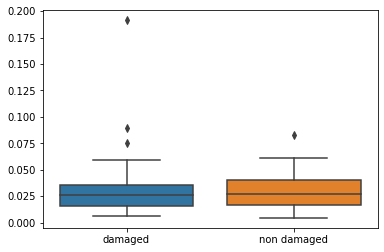

In [160]:
data = {'damaged':dams_reconstruction,'non damaged':no_dams_reconstruction}
df = pd.DataFrame(data=data)
sns.boxplot(data=df)

In [156]:
from sklearn.linear_model import LogisticRegression

In [158]:
from sklearn.linear_model import LogisticRegression

X_clf=[]

for i in range(len(no_dams_reconstruction)):
    X_clf.append([no_dams_reconstruction[i],no_dams_seg[i]])
for i in range(len(dams_reconstruction)):
    X_clf.append([dams_reconstruction[i],dams_seg[i]])

X_clf = np.array(X_clf)


y_clf = [0]*10+[1]*10
clf = LogisticRegression()
clf.fit(np.array(X_clf).reshape(-1,2),np.array(y_clf).reshape(-1, 1))

print(clf.score(X_clf,y_clf))


0.6


In [106]:


wn.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/WnetDropoutIdea/ckpt5300")

In [124]:
dams_reconstruction = []
no_dams_reconstruction = []

dams_seg = []
no_dams_seg = []

#damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True)
#non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False)




sigma=5
blur_kernel=10
noise_amp=0.1

for i in range(0,4):
    print(i)
    no_dams = tf.convert_to_tensor(non_damaged_generator.__getitem__(i))   
    dams = tf.convert_to_tensor(damaged_generator.__getitem__(i))
    for no_dam in no_dams:
      
        input_ = no_dam
        input_=tf.expand_dims(input_,0)


        seg = wn.encoder(input_noisy)
        seg_loss = ncut_loss.compute_soft_ncuts(input_,seg,neighbor_filter).numpy()

        reconstruction = wn(input_)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(input_,wn(reconstruction)).numpy()



        no_dams_reconstruction.append(reconstruction_loss)
        no_dams_seg.append(seg_loss)

    for no_dam in dams:
        input_ = no_dam

       
        input_=tf.expand_dims(input_,0)

        #plt.imshow(rescale(np.array(input_noisy))[0])

        seg = wn.encoder(input_)
        seg_loss = ncut_loss.compute_soft_ncuts(input_,seg,neighbor_filter).numpy()

        reconstruction = wn(input_)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(input_,wn(reconstruction)).numpy()

        dams_reconstruction.append(reconstruction_loss)
        dams_seg.append(seg_loss)

    

0
1
2
3


<AxesSubplot:>

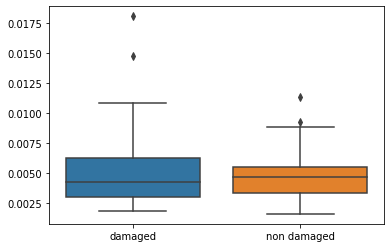

In [125]:
data = {'damaged':dams_reconstruction,'non damaged':no_dams_reconstruction}
df = pd.DataFrame(data=data)
sns.boxplot(data=df)

In [ ]:
X_test=[]

for i in range(len(ndams_reco_test)):
    X_test.append([ndams_reco_test[i],ndams_seg_test[i]])
for i in range(len(dams_reco_test)):
    X_test.append([dams_reco_test[i],dams_seg_test[i]])

X_test = np.array(X_test)
print(X_test.shape)

In [ ]:
#X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*51+[1]*51

pred = clf.predict(np.array(X_test).reshape(-1,2))

clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


In [ ]:
#X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*51+[1]*51

pred = clf.predict(np.array(X_test).reshape(-1,2))

clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


In [ ]:
dam = dam_gen.__getitem__(np.random.randint(50,100))
#print(ndam.shape)
plt.figure(figsize=(5,5))
plt.imshow(dam[0])

dam=tf.convert_to_tensor(dam)  
#seg_dam = wn.encoder(dam)
seg_dam = wn.encoder(dam)

#seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)


seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
loss_reco = (tf.keras.losses.MeanSquaredError()(dam,wn(dam)).numpy())
print(seg_loss_dam,loss_reco)


clf.predict(np.array([loss_reco,seg_loss_dam]).reshape(1, -1))

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, pred))

# TEST DROPOUT 

In [ ]:
dams_reco = []
ndams_reco = []

dams_seg = []
ndams_seg = []

#damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True)
#non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False)

for i in range(0,10):
    print(i)
    no_dam = tf.convert_to_tensor(non_damaged_generator.__getitem__(i))   
    dam = tf.convert_to_tensor(damaged_generator.__getitem__(i))
    
    seg_dam = wn.encoder(dam)
    seg_no_dam = wn.encoder(no_dam)
    
    seg_loss_no_dam = ncut_loss.compute_soft_ncuts(no_dam,seg_no_dam,neighbor_filter)
    seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
    
    dams_seg.append(seg_loss_dam.numpy())
    ndams_seg.append(seg_loss_no_dam.numpy())
    
    dams_reco.append(tf.keras.losses.MeanSquaredError()(dam,wn(dam)).numpy())
    ndams_reco.append(tf.keras.losses.MeanSquaredError()(no_dam,wn(no_dam)).numpy())
    

In [ ]:
len(dam_gen)